In [12]:
# NumPy: 数値計算を効率的に行うためのライブラリ
import numpy as np

# Pandas: データ分析を容易にするためのライブラリ
import pandas as pd

# Matplotlib: グラフ描画のためのライブラリ
import matplotlib.pyplot as plt

# Scikit-learn: 機械学習のためのライブラリ
from sklearn.decomposition import PCA  # 主成分分析 (PCA) を行うためのモジュール

# SciPy: 科学技術計算のためのライブラリ
from scipy.stats import norm  # 正規分布に関連する関数を扱うモジュール

## <span style="color: DeepPink; ">4.4.3 PCAローディングの性質をpythonで確認する</span>

### <span style="color: blue; ">トマトのリコピン量・糖度データにPCA</span>

In [13]:
# データフレームの作成
data = {'リコピン量(mg/100g)': [7, 8, 9, 10, 11],
        '糖度(%)': [6, 6, 7, 9, 9]}
df = pd.DataFrame(data)

# 平均と不偏分散の計算
df_mean = df.mean()
df_var = df.var()

# 新しいデータフレームに平均と不偏分散を追加
df_stats = pd.concat([df, pd.DataFrame([df_mean, df_var], index=['平均', '不偏分散'])])

# 中心化
df_centered = df - df_mean

# PCAの実行
pca = PCA(n_components=2)
df_pca = pd.DataFrame(pca.fit_transform(df_centered), columns=['第1主成分', '第2主成分'])

# PCAの結果をデータフレームに追加
df_pca_stats = pd.concat([df_pca, pd.DataFrame([df_pca.mean(), df_pca.var()], index=['平均', '不偏分散'])])
explained_variance_ratio = pca.explained_variance_ratio_

# PCAのローディング（主成分の貢献度）を計算
loadings = pca.components_.T
df_loadings = pd.DataFrame(loadings, columns=['第1主成分のローディング', '第2主成分のローディング'], index=['リコピン量(mg/kg)', '糖度(Brix)'])

# 寄与率をデータフレームに変換
df_explained_variance_ratio = pd.DataFrame(explained_variance_ratio, 
                                           columns=['寄与率'], 
                                           index=['第1主成分', '第2主成分'])

print("データは:\n",df_stats,"\n")
print("平均化データは:\n",df_centered,"\n")
print("主成分スコアは:\n",round(df_pca_stats,2),"\n")
print("ローディングは:\n",round(df_loadings,2),"\n")
print("寄与率は:\n",round(df_explained_variance_ratio,4))


データは:
       リコピン量(mg/100g)  糖度(%)
0                7.0    6.0
1                8.0    6.0
2                9.0    7.0
3               10.0    9.0
4               11.0    9.0
平均               9.0    7.4
不偏分散             2.5    2.3 

平均化データは:
    リコピン量(mg/100g)  糖度(%)
0            -2.0   -1.4
1            -1.0   -1.4
2             0.0   -0.4
3             1.0    1.6
4             2.0    1.6 

主成分スコアは:
       第1主成分  第2主成分
0     -2.41   0.37
1     -1.69  -0.32
2     -0.28  -0.29
3      1.83   0.46
4      2.55  -0.23
平均    -0.00  -0.00
不偏分散   4.65   0.15 

ローディングは:
               第1主成分のローディング  第2主成分のローディング
リコピン量(mg/kg)          0.72         -0.69
糖度(Brix)              0.69          0.72 

寄与率は:
           寄与率
第1主成分  0.9692
第2主成分  0.0308


### <span style="color: blue; ">スペクトルデータにPCA</span>

#### 正規分布を三つ重ねる

In [14]:
# 3つの正規分布を合わせる関数
def make_normal(wave, d_std, d_posi, d_inten, noiselevel):
    """
    吸収スペクトルデータ（A）と既知の濃度データ（C）を使用して、検量線（K）と予測濃度（predC）を計算し、
    吸収スペクトルと検量線をプロットする関数。

    Parameters:
    wave (numpy.ndarray): 波長データ
    d_std (numpy.ndarray): 正規分布の標準偏差
    d_posi (numpy.ndarray): 正規分布の位置（平均）
    d_inten (numpy.ndarray): 各試料の各正規分布に対する強度
    noiselevel (float): ノイズレベル

    Returns:
    numpy.ndarray: 各試料の吸収スペクトルデータ
    """
    len_wave = len(wave)  # 横軸の長さ
    len_sample = len(d_inten)  # 試料数
    len_nd = len(d_std)  # 合わせる正規分布の数
    Xall = np.zeros((len_wave, len_sample))  # 行数：波長数、列数サンプル数のゼロ行列

    for i in range(len_sample):  # 各サンプルに対して
        for k in range(len_nd):  # 各正規分布に対して
            Xall[:, i] = Xall[:, i] + d_inten[i, k] * norm.pdf(wave, d_posi[k], d_std[k])
        # ノイズの追加
        Xall[:, i] = Xall[:, i] + noiselevel * np.max(Xall[:, i]) * (0.5 - np.random.randn(len_wave))

    plt.figure(figsize=(10, 6))
    plt.plot(wave, Xall)
    for k in range(len_nd):
        plt.plot(wave, norm.pdf(wave, d_posi[k], d_std[k]), 'black')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

    Xall = Xall.transpose()  # スペクトルを扱うときは行がサンプル、列が波長
    return Xall

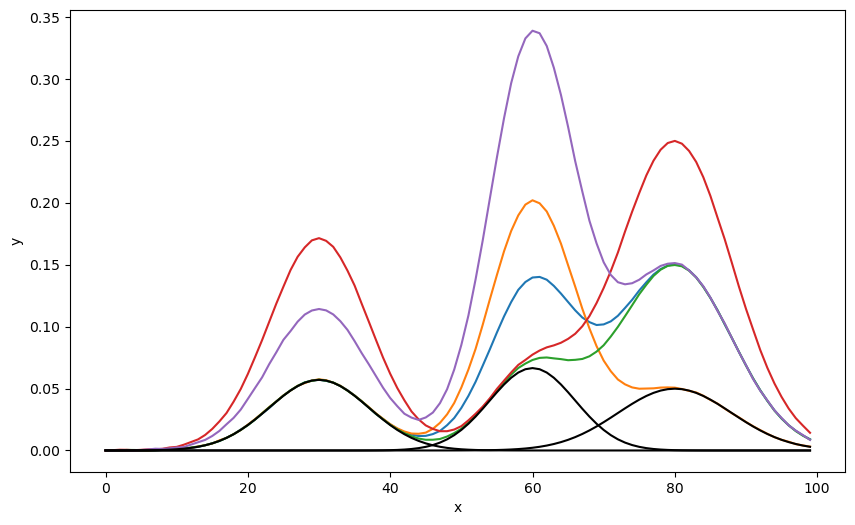

In [15]:
wave=np.arange(0,100,1)
d_std=np.array([7,6,8])
d_posi=np.array([30,60,80])
d_inten=np.array([[1,2,3],[1,3,1],[1,1,3],[3,1,5],[2,5,3]])
nd_Xall=make_normal(wave,d_std,d_posi,d_inten,0.001)

#### PCAを行いローディングを確認する

In [16]:
# PCAのインスタンス化と主成分数の設定
pca = PCA(n_components=5)  # 5つの主成分を使用
pca.fit(nd_Xall)# PCAによる学習（主成分の方向の計算）
score = pca.transform(nd_Xall) # スコア（主成分スコア）の計算
loading = pca.components_  # ローディング（各主成分の貢献度）の計算
explainedv = pca.explained_variance_ratio_  # 各主成分の寄与率の計算

check_orth = loading.dot(loading.T)  # ローディングベクトル間の内積（直交性の確認）
print(np.round(check_orth, 1))  # 直交性の結果を小数点以下1桁で丸めて表示

[[ 1.  0.  0.  0. -0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1. -0.]
 [-0.  0.  0. -0.  1.]]


## <span style="color: DeepPink; ">4.4.6 中心化と標準化によるPCAローディングの変化をPythonで確認する</span>

### <span style="color: blue; ">平均化と標準化</span>

In [17]:
df_Xall=pd.DataFrame(nd_Xall)
df_Xall_meaned=(df_Xall-df_Xall.mean()) # 平均化
df_Xall_normalized=df_Xall_meaned/df_Xall.std(ddof=1) # 標準化

### <span style="color: blue; ">SVDによるPCA</span>

In [18]:
def PCAbySVD(X):
    """
    特異値分解(SVD)を用いてPCAを実行する関数。
    
   パラメーター:
    X (numpy array): サンプルと変数を持つ2次元配列。

    戻り値:
    tuple: 寄与率 (svd_explained)、スコア (svd_score)、ローディング (svd_loading) を含むタプル。
    """
    # 特異値分解を実行
    U, singular_values, VT = np.linalg.svd(X, full_matrices=False)
    
    # 寄与率を計算
    svd_explained = (singular_values ** 2) / np.sum(singular_values ** 2)
    
    # スコアを計算
    svd_score = np.dot(U, np.diag(singular_values))
    
    # ローディングはVTによって与えられる
    svd_loading = VT

    return svd_explained, svd_score, svd_loading

### <span style="color: blue; ">中心化・標準化によるPCAローディングの変化をpythonで確認</span>

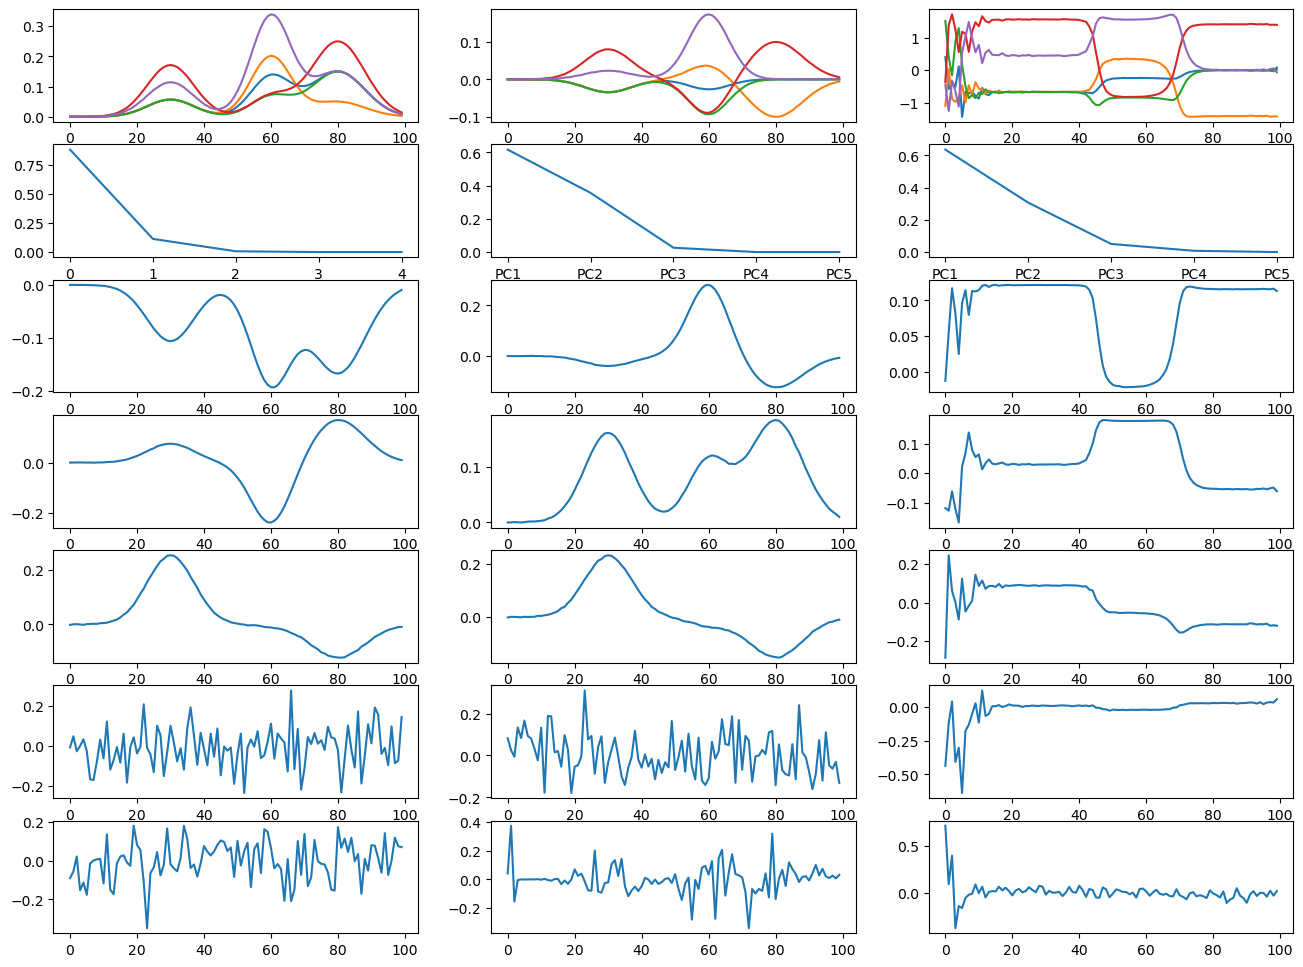

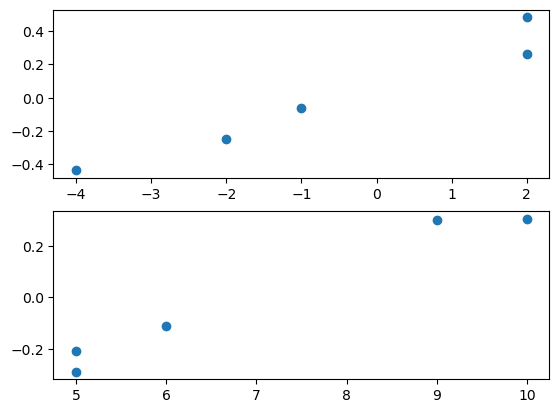

In [19]:
def PCAbySVD(X):
    U, singular_values, VT = np.linalg.svd(X, full_matrices=False)
    svd_explained = (singular_values ** 2) / np.sum(singular_values ** 2)
    svd_score = np.dot(U, np.diag(singular_values))
    svd_loading = VT
    return svd_explained, svd_score, svd_loading

# オリジナルスペクトルに対するPCA
svd_explained, svd_score, svd_loading = PCAbySVD(df_Xall)
score_original = pd.DataFrame(svd_score)
loading_original = pd.DataFrame(svd_loading)
explained_original = pd.DataFrame(svd_explained)

# 平均化スペクトルに対するPCA
num_comp = 5
pca = PCA(n_components=num_comp)
pca.fit(df_Xall)
feature = pca.transform(df_Xall)
score_meaned = pd.DataFrame(feature, columns=["PC{}".format(x+1) for x in range(num_comp)])
loading_meaned = pd.DataFrame(pca.components_, index=["PC{}".format(x+1) for x in range(num_comp)])
explained_meaned = pd.DataFrame(pca.explained_variance_ratio_, index=["PC{}".format(x+1) for x in range(num_comp)])

# 標準化スペクトルに対するPCA
pca.fit(df_Xall_normalized)
feature = pca.transform(df_Xall_normalized)
score_normalized = pd.DataFrame(feature, columns=["PC{}".format(x+1) for x in range(num_comp)])
loading_normalized = pd.DataFrame(pca.components_, index=["PC{}".format(x+1) for x in range(num_comp)])
explained_normalized = pd.DataFrame(pca.explained_variance_ratio_, index=["PC{}".format(x+1) for x in range(num_comp)])

# 結果の図示
fig, axes = plt.subplots(num_comp + 2, 3, figsize=(16, 12))
axes[0][0].plot(df_Xall.T)
axes[0][1].plot(df_Xall_meaned.T)  # df_Xall_meaned は平均化されたデータを指す必要がある
axes[0][2].plot(df_Xall_normalized.T)
axes[1][0].plot(explained_original)
axes[1][1].plot(explained_meaned)
axes[1][2].plot(explained_normalized)
for i in range(num_comp):
    axes[i + 2][0].plot(loading_original.iloc[i, :])
    axes[i + 2][1].plot(loading_meaned.iloc[i, :])
    axes[i + 2][2].plot(loading_normalized.iloc[i, :])

fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.scatter(d_inten[:, 1] - d_inten[:, 2], score_meaned.iloc[:, 0])  # d_inten は別途定義される必要がある
ax2 = fig.add_subplot(2, 1, 2)
ax2.scatter(np.sum(d_inten, axis=1), score_meaned.iloc[:, 1])

plt.show()


## <span style="color: DeepPink; ">4.4.8スコアとローディングによるスペクトルの再構築をpythonで確認する</span>

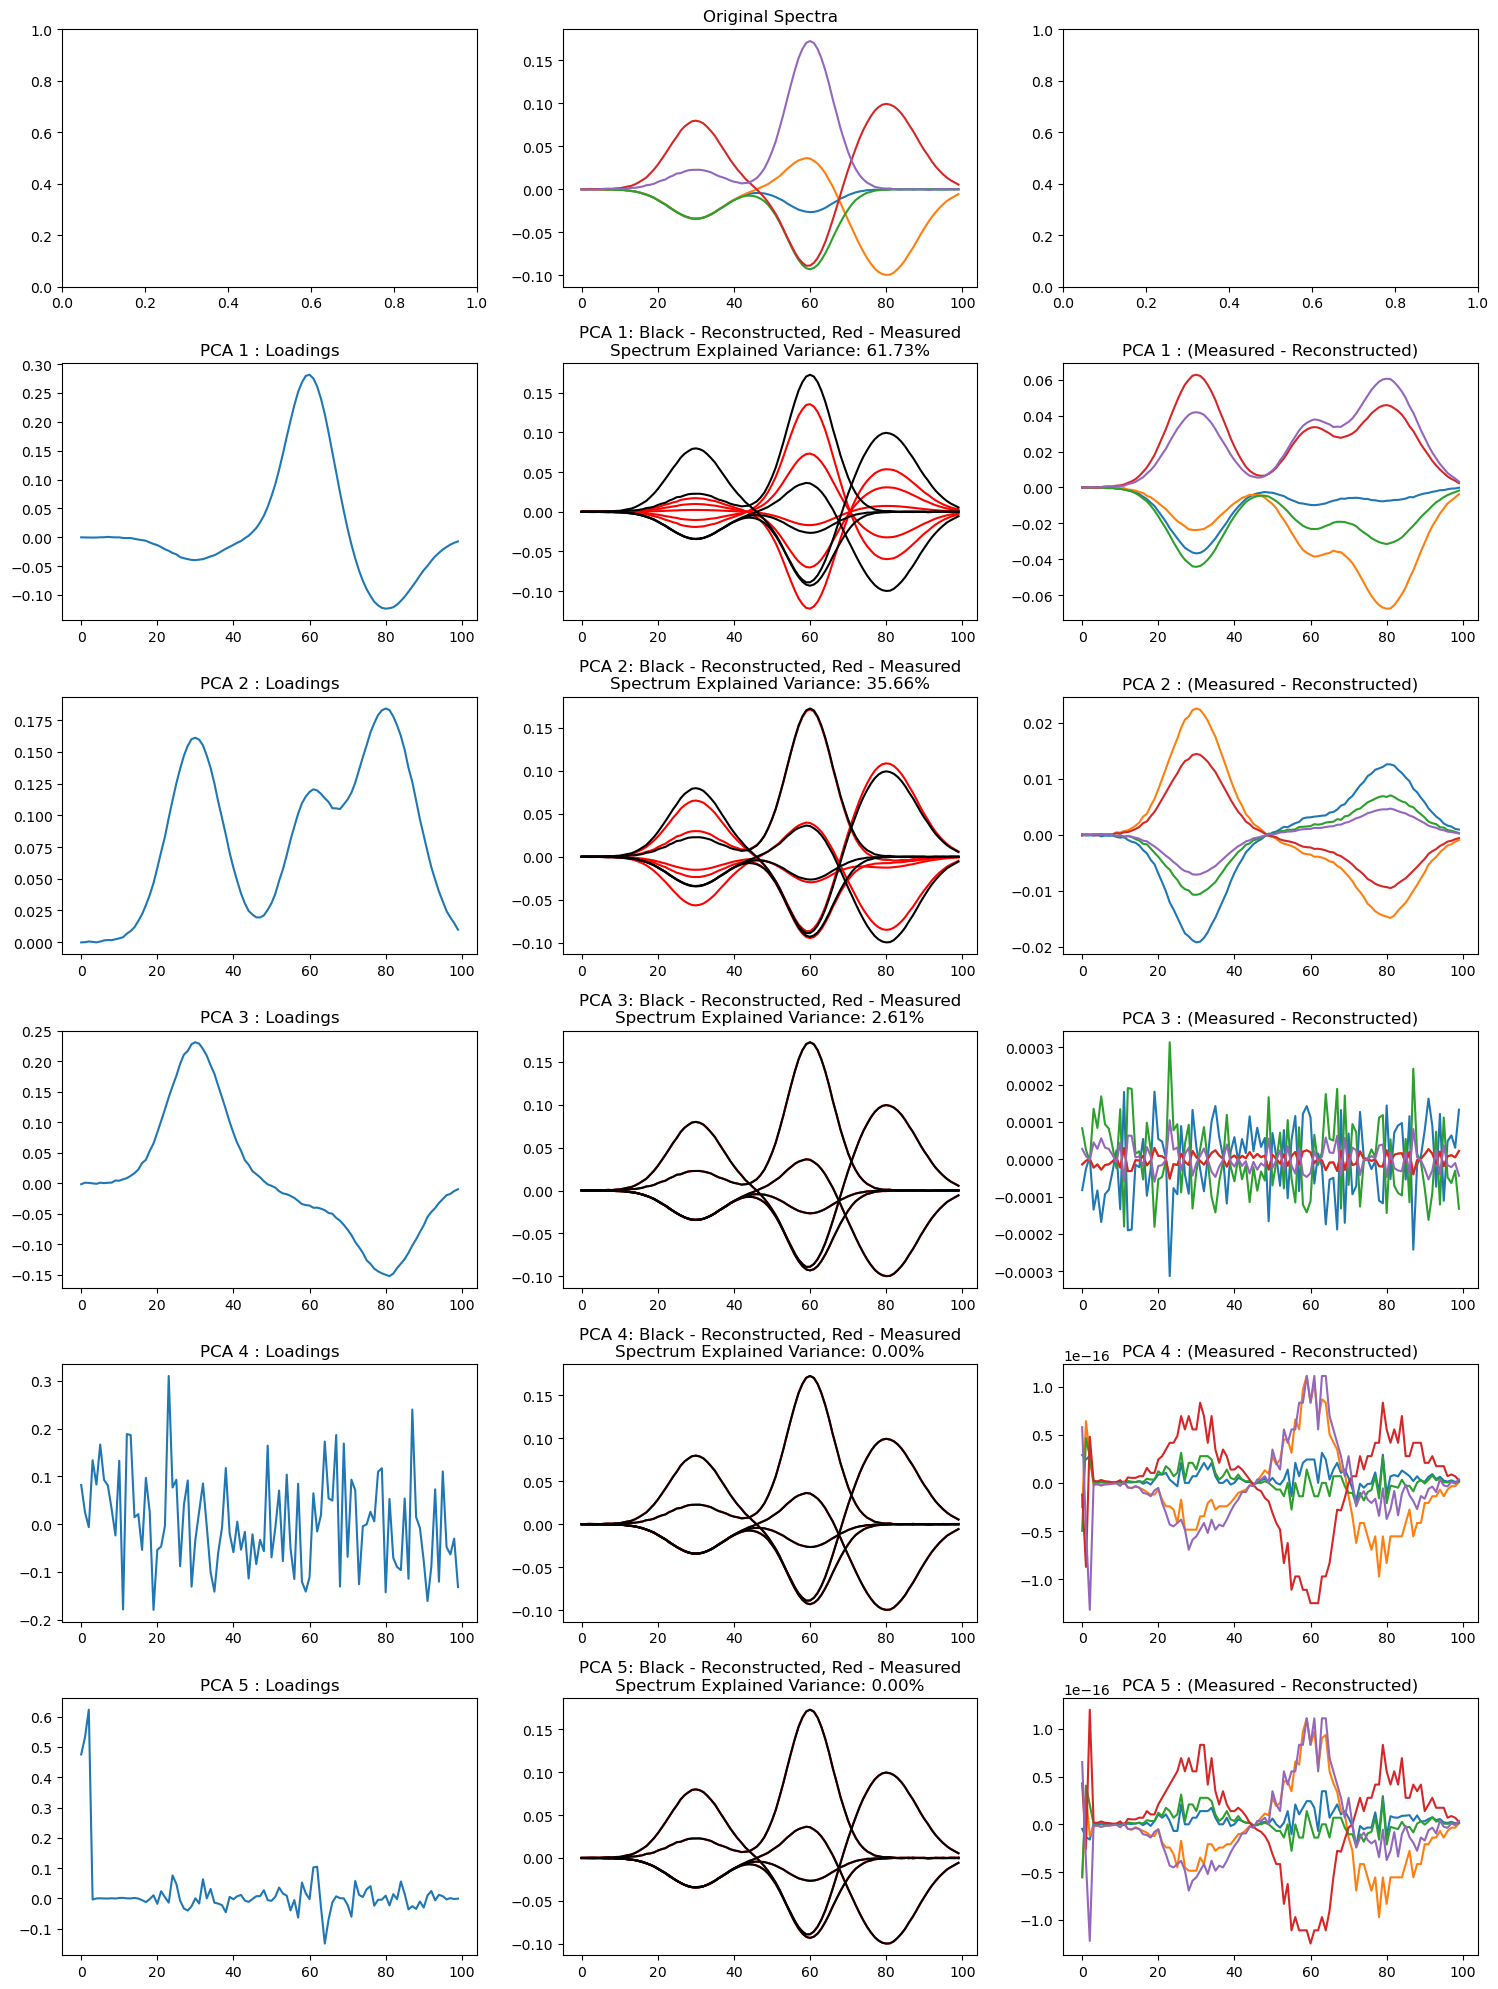

In [20]:
num_components = 5

# PCAの実行
pca = PCA(n_components=num_components)
pca.fit(df_Xall_meaned)
scores = pca.transform(df_Xall_meaned)
loadings = pca.components_
explained_variance = pca.explained_variance_ratio_

# 図の作成
fig, axs = plt.subplots(6, 3, figsize=(15, 20))

# 元のスペクトルのプロット
axs[0, 1].plot(df_Xall_meaned.T)
axs[0, 1].set_title('Original Spectra')

# PCAの結果のプロット
for i in range(num_components):
    # ローディングのプロット
    axs[i + 1, 0].plot(loadings[i, :])
    axs[i + 1, 0].set_title(f'PCA {i + 1} : Loadings')

    # 再構成されたスペクトルの計算
    reconstructed = np.dot(scores[:, :i + 1], loadings[:i + 1, :])
    # 残差スペクトルの計算
    residual_spectra = df_Xall_meaned - reconstructed

    # 残差スペクトルのプロット
    axs[i + 1, 2].plot(residual_spectra.T)
    axs[i + 1, 2].set_title(f'PCA {i + 1} : (Measured - Reconstructed)')

    # 再構成されたスペクトルと元のスペクトルのプロット
    axs[i + 1, 1].plot(reconstructed.T, color='red')
    axs[i + 1, 1].plot(df_Xall_meaned.T, color='black')
    axs[i + 1, 1].set_title(f'PCA {i + 1}: Black - Reconstructed, Red - Measured\n'
                            f'Spectrum Explained Variance: {explained_variance[i] * 100:.2f}%')

plt.tight_layout()
plt.show()
